In [10]:
import pandas as pd
import numpy as np
import os
import sys
from random import randrange
import scipy

import librosa # For analyzing audio and music, extracting the data from the audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio # To play the audio files

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import concurrent.futures

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## RAVDESS Dataset

In [11]:
Ravdess = r"data\input\Ravdess\audio_speech_actors_01-24"

# List directories in the RAVDESS dataset path
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # List files for each actor in the directory
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0].split('-')
        # Third part in each file represents the emotion associated to that file
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# Create a dataframe for emotions of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a dataframe for paths of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace integer labels with actual emotion names
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

# Display the first few rows of the dataframe
Ravdess_df.head(20)

,Emotions,Path
0,neutral,data\input\Ravdess\audio_speech_actors_01-24\A...
1,neutral,data\input\Ravdess\audio_speech_actors_01-24\A...
2,neutral,data\input\Ravdess\audio_speech_actors_01-24\A...
3,neutral,data\input\Ravdess\audio_speech_actors_01-24\A...
4,calm,data\input\Ravdess\audio_speech_actors_01-24\A...
5,calm,data\input\Ravdess\audio_speech_actors_01-24\A...
6,calm,data\input\Ravdess\audio_speech_actors_01-24\A...
7,calm,data\input\Ravdess\audio_speech_actors_01-24\A...
8,calm,data\input\Ravdess\audio_speech_actors_01-24\A...
9,calm,data\input\Ravdess\audio_speech_actors_01-24\A...


## CREMA Dataset

In [12]:
Crema = r"data\input\Crema"

# List directories in the CREMA dataset path
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Crema, file))
    # Storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Crema_df.head(20)

,Emotions,Path
0,angry,data\input\Crema\1001_DFA_ANG_XX.wav
1,disgust,data\input\Crema\1001_DFA_DIS_XX.wav
2,fear,data\input\Crema\1001_DFA_FEA_XX.wav
3,happy,data\input\Crema\1001_DFA_HAP_XX.wav
4,neutral,data\input\Crema\1001_DFA_NEU_XX.wav
5,sad,data\input\Crema\1001_DFA_SAD_XX.wav
6,angry,data\input\Crema\1001_IEO_ANG_HI.wav
7,angry,data\input\Crema\1001_IEO_ANG_LO.wav
8,angry,data\input\Crema\1001_IEO_ANG_MD.wav
9,disgust,data\input\Crema\1001_IEO_DIS_HI.wav


## TESS Dataset

In [13]:
Tess = r"data\input\Tess"

# List directories in the TESS dataset path
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0].split('_')[2]
        # Handle the 'ps' for surprise, if it is there
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part.lower())  # Convert to lowercase for consistency
        file_path.append(os.path.join(Tess, dir, file))

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Tess_df.head(30)

,Emotions,Path
0,angry,data\input\Tess\OAF_angry\OAF_back_angry.wav
1,angry,data\input\Tess\OAF_angry\OAF_bar_angry.wav
2,angry,data\input\Tess\OAF_angry\OAF_base_angry.wav
3,angry,data\input\Tess\OAF_angry\OAF_bath_angry.wav
4,angry,data\input\Tess\OAF_angry\OAF_bean_angry.wav
5,angry,data\input\Tess\OAF_angry\OAF_beg_angry.wav
6,angry,data\input\Tess\OAF_angry\OAF_bite_angry.wav
7,angry,data\input\Tess\OAF_angry\OAF_boat_angry.wav
8,angry,data\input\Tess\OAF_angry\OAF_bone_angry.wav
9,angry,data\input\Tess\OAF_angry\OAF_book_angry.wav


## SAVEE Dataset

In [14]:
Savee = r"data\input\Savee"

# List directories in the SAVEE dataset path
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Savee, file))
    # Storing file emotions
    part = file.split('_')[1]
    ele = part[:2] if part.startswith('s') else part[0]
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    elif ele == 'su':
        file_emotion.append('surprise')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Savee_df.head(20)

,Emotions,Path
0,angry,data\input\Savee\DC_a01.wav
1,angry,data\input\Savee\DC_a02.wav
2,angry,data\input\Savee\DC_a03.wav
3,angry,data\input\Savee\DC_a04.wav
4,angry,data\input\Savee\DC_a05.wav
5,angry,data\input\Savee\DC_a06.wav
6,angry,data\input\Savee\DC_a07.wav
7,angry,data\input\Savee\DC_a08.wav
8,angry,data\input\Savee\DC_a09.wav
9,angry,data\input\Savee\DC_a10.wav


In [15]:
# Combining datasets into one dataframe
data_df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_df.head()
# Checking label counts
data_df.Emotions.value_counts()

Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1922
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

In [16]:
# Combining neutral and calm instances
data_df.loc[data_df['Emotions'] == 'neutral','Emotions'] = "calm"
# Checking label counts
data_df.Emotions.value_counts()

Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1922
calm        1895
surprise     652
Name: count, dtype: int64

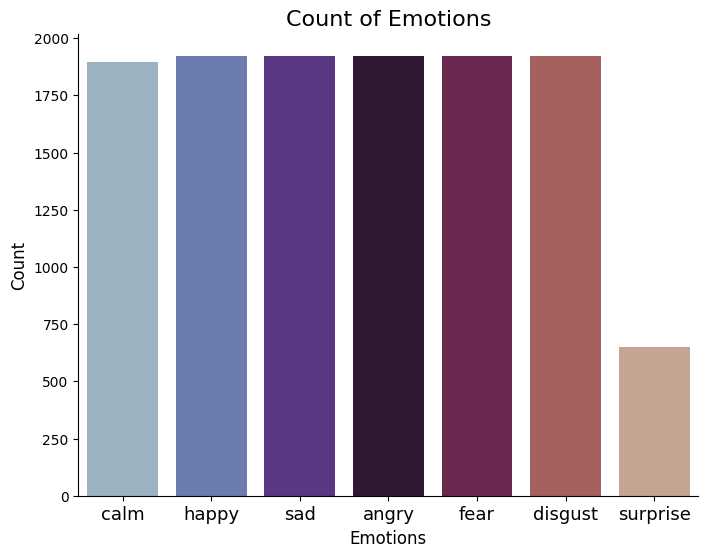

In [17]:
# Plot to see counts of labels
plt.figure(figsize=(8 ,6))
plt.title('Count of Emotions', size=16)
# Google drive plot
sns.countplot(data=data_df, x="Emotions", hue="Emotions", palette="twilight", legend=False)
# Kaggle plot
# sns.countplot(data=data_df, x="Emotions")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tick_params(axis='x', labelsize=13)
plt.show()

In [18]:
# Function to plot waveform
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Amplitude', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

# Function to plot spectrogram
def create_spectrogram(data, sr, emo):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    # Convert frequency into decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(11, 3))
    plt.title(f'Spectrogram for audio with {emo} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Hz', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.colorbar()

# Combine all plot functions
def combine_plots(data, emo):
    # Randomly select data instance of given emotion
    data_path = data[data['Emotions'] == emo]['Path'].iloc[randrange(len(data[data['Emotions'] == emo]))]
    data, sr = librosa.load(data_path)
    create_waveplot(data, sr, emo)
    create_spectrogram(data, sr, emo)
    return data, sr

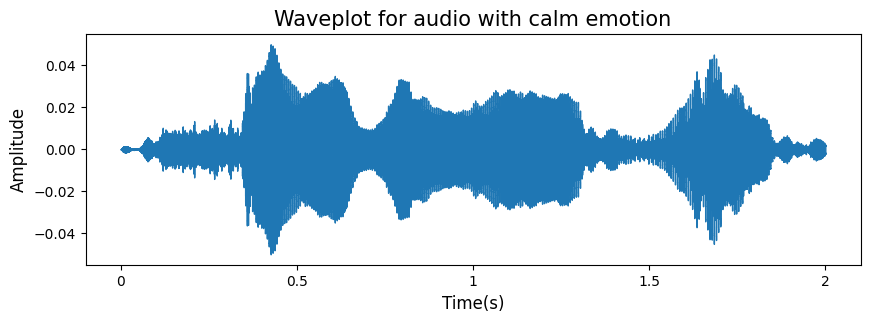

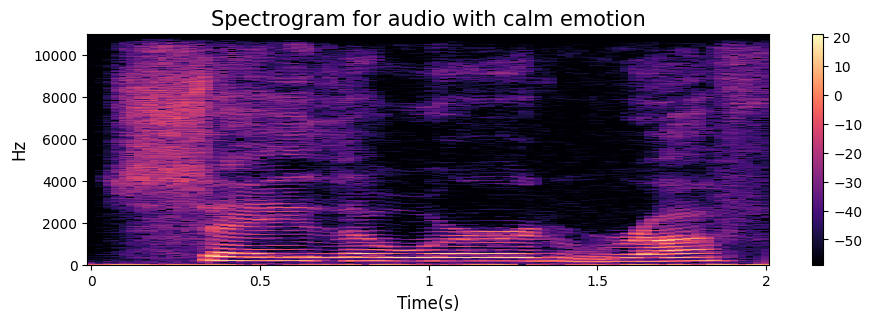

In [19]:
emo = 'calm'
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

# Data Augmentation

In [20]:
# Function to introduce noise in the audio
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data
# Function to stretch audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Function to change the pitch of the data
def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

In [21]:
# Sample audio path for demonstration
path = data_df['Path'].iloc[randrange(len(data_df))]
data, sample_rate = librosa.load(path)

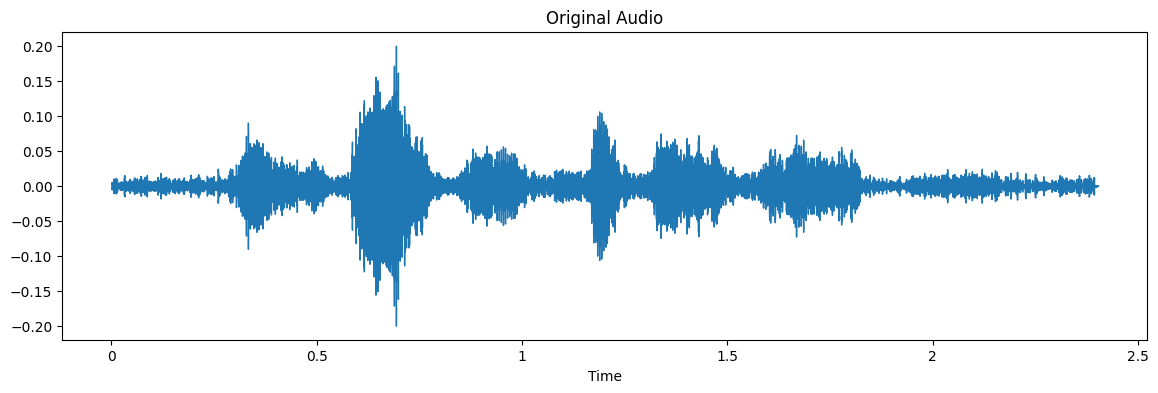

In [22]:
# Simple Audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title('Original Audio')
plt.show()
display(Audio(data, rate=sample_rate))

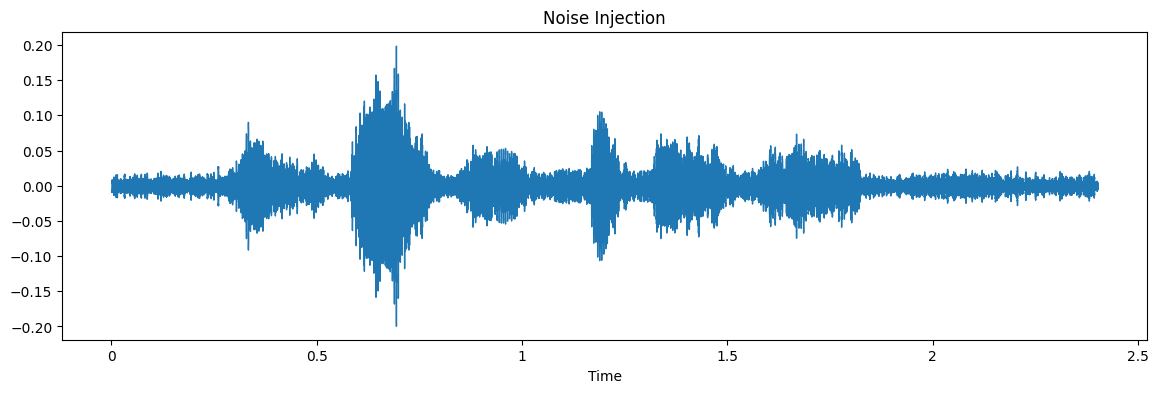

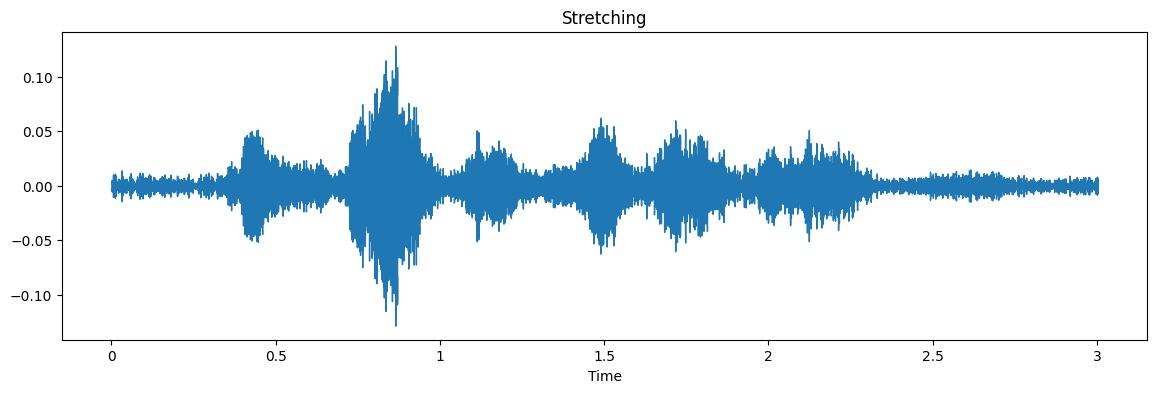

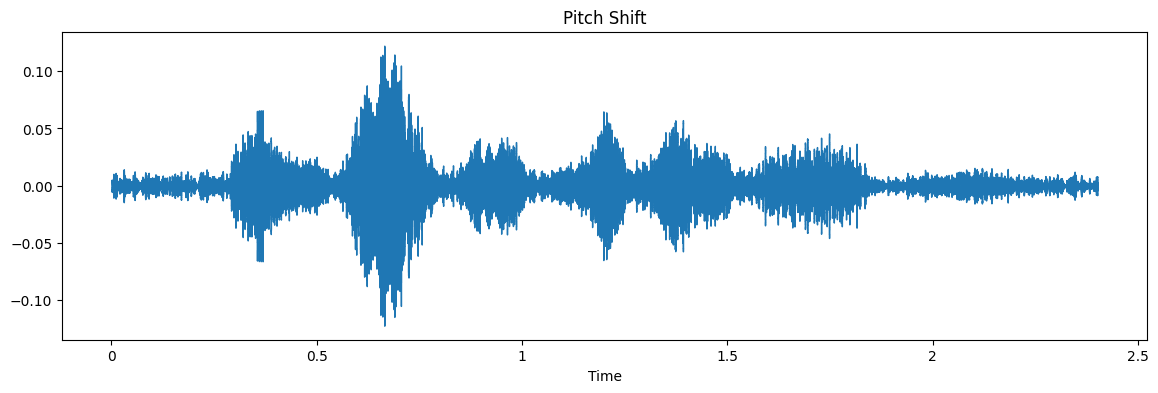

In [23]:
# Introducing noise in audio file
x = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Noise Injection')
plt.show()
Audio(x, rate=sample_rate)
# Stretching the audio file
x = stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Stretching')
plt.show()
display(Audio(x, rate=sample_rate))
# Shifting the pitch of audio file
x = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Pitch Shift')
plt.show()
display(Audio(x, rate=sample_rate))

In [24]:
# Function to extract features
def extract_features(data, sample_rate):
    # MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    # Energy
    energy = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # Entropy of energy (computed as entropy of the short-term energy)
    st_energy = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    entropy_of_energy = np.mean([scipy.stats.entropy(e) for e in st_energy])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Mel-Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)

    # Spectral Spread
    spectral_spread = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)

    # Spectral Roll-off
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)

    # Concatenate all features
    features = np.hstack((mfcc, energy, entropy_of_energy, zcr, mel, spectral_centroid, spectral_spread, spectral_rolloff))
    return features

# Function to apply extract_features on data
def get_features(path):
  data, sample_rate = librosa.load(path, duration=3, offset=0.3)

  # Simple Audio
  simple = extract_features(data, sample_rate)

  # Noisy audio
  noisy = extract_features(noise(data), sample_rate)

  # Stretching
  stretched = extract_features(stretch(data), sample_rate)

  # Pitch shifting
  pitch_shifted = extract_features(pitch(data, sample_rate), sample_rate)

  # Concatenate
  features = np.vstack((simple, noisy, stretched, pitch_shifted))
  return features

In [25]:
def process_file(path, emotion):
    features = get_features(path)
    return [(feature, emotion) for feature in features]
X, y = [], []
c = 0
# Use ThreadPoolExecutor for I/O bound tasks or ProcessPoolExecutor for CPU bound tasks
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a list of futures
    futures = [executor.submit(process_file, path, emotion) for path, emotion in zip(data_df.Path, data_df.Emotions)]

    # As each future completes, process the results
    for future in concurrent.futures.as_completed(futures):
        results = future.result()
        for feature, emotion in results:
            X.append(feature)
            y.append(emotion)
            c += 1
        print(f"Processed {c} files")

Processed 4 files
Processed 8 files
Processed 12 files
Processed 16 files
Processed 20 files
Processed 24 files
Processed 28 files
Processed 32 files
Processed 36 files
Processed 40 files
Processed 44 files
Processed 48 files
Processed 52 files
Processed 56 files
Processed 60 files
Processed 64 files
Processed 68 files
Processed 72 files
Processed 76 files
Processed 80 files
Processed 84 files
Processed 88 files
Processed 92 files
Processed 96 files
Processed 100 files
Processed 104 files
Processed 108 files
Processed 112 files
Processed 116 files
Processed 120 files
Processed 124 files
Processed 128 files
Processed 132 files
Processed 136 files
Processed 140 files
Processed 144 files
Processed 148 files
Processed 152 files
Processed 156 files
Processed 160 files
Processed 164 files
Processed 168 files
Processed 172 files
Processed 176 files
Processed 180 files
Processed 184 files
Processed 188 files
Processed 192 files
Processed 196 files
Processed 200 files
Processed 204 files
Proces

In [26]:
# Length of features and labels
len(X), len(y)

(48644, 48644)

In [27]:
# Create dataframe of features and labels
data_df = pd.DataFrame(X)
data_df["Labels"] = y
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,Labels
0,-670.053345,60.513130,2.894017,14.619364,7.038566,2.438358,-1.832954,-7.095846,-11.171360,-4.136311,...,0.000070,0.000035,0.000032,0.000035,0.000020,1.367882e-06,3067.961415,2643.381970,6027.473499,calm
1,-437.500286,22.034539,8.422179,8.565357,3.083232,0.758318,-1.879075,-5.879280,-6.423852,-3.672252,...,0.000144,0.000105,0.000101,0.000105,0.000093,7.603632e-05,4568.774433,3148.737985,8430.683161,calm
2,-712.793945,62.069489,1.969594,14.619805,6.268817,2.207972,-1.988648,-8.025400,-12.354299,-5.127701,...,0.000034,0.000016,0.000016,0.000017,0.000009,5.955026e-07,3074.098909,2658.949002,6050.621692,calm
3,-712.483093,62.657005,1.625614,15.325785,5.270883,1.603082,-4.510453,-10.520849,-12.625965,-3.167397,...,0.000007,0.000024,0.000031,0.000013,0.000008,1.228391e-06,3026.262749,2638.343810,5992.742526,calm
4,-616.331177,85.680885,-5.479952,18.854061,8.419351,3.422035,-6.133804,-11.195700,-13.204558,-5.238554,...,0.000018,0.000020,0.000022,0.000023,0.000016,1.029514e-06,2678.588284,2220.430552,4730.927547,calm


# Data Preprocessing

In [28]:
# Check for null values
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")
# Drop null values
data_df.dropna(inplace=True)
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")
# Check value of counts of labels
data_df.Labels.value_counts()

Null values in dataframe: 4
Shape of dataframe: (48644, 155)
Null values in dataframe: 0
Shape of dataframe: (48640, 155)


Labels
happy       7692
angry       7692
fear        7692
sad         7688
disgust     7688
calm        7580
surprise    2608
Name: count, dtype: int64

In [32]:
# Handle imbalanced label "surprise" by creating fake data instances
# Synthetic Minority Over-sampling Technique (SMOTE)

from imblearn.over_sampling import SMOTE
data_df.columns = data_df.columns.astype(str)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(data_df.iloc[:,:-1], data_df["Labels"])
# Check length of resampled data
len(X_resampled), len(y_resampled)
# Recreate dataframe using resampled data
data_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_df.head()
# Check value counts of each label in new dataframe
data_df.Labels.value_counts()
data_df.to_csv("data/input/combinedfor1d.csv", index = False)